In [1]:
from google.colab import files
uploaded=files.upload()

Saving workout_fitness_tracker_data.csv to workout_fitness_tracker_data.csv


In [9]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("workout_fitness_tracker_data.csv")
print(df.head())
print(df.info())

   User ID  Age  Gender  Height (cm)  Weight (kg) Workout Type  \
0        1   39    Male          175           99      Cycling   
1        2   36   Other          157          112       Cardio   
2        3   25  Female          180           66         HIIT   
3        4   56    Male          154           89      Cycling   
4        5   53   Other          194           59     Strength   

   Workout Duration (mins)  Calories Burned  Heart Rate (bpm)  Steps Taken  \
0                       79              384               112         8850   
1                       73              612               168         2821   
2                       27              540               133        18898   
3                       39              672               118        14102   
4                       56              410               170        16518   

   Distance (km) Workout Intensity  Sleep Hours  Water Intake (liters)  \
0          14.44              High          8.2             

In [4]:
def assign_dropout_status(record):
    mood_start = record['Mood Before Workout']
    mood_end = record['Mood After Workout']
    workout_level = record['Workout Intensity']
    time_spent = record['Workout Duration (mins)']

    if (mood_start in ['Tired', 'Stressed', 'Neutral'] and
        mood_end in ['Fatigued', 'Neutral'] and
        workout_level == 'Low' and
        time_spent < 30):
        return 1
    return 0

In [7]:
df['DropoutFlag'] = df.apply(assign_dropout_status, axis=1)
print(df['DropoutFlag'].value_counts())

DropoutFlag
0    9690
1     310
Name: count, dtype: int64


In [10]:
cat_features = df.select_dtypes(include=['object']).columns
cat_features = cat_features.drop(['Mood Before Workout', 'Mood After Workout'])
print("Categorical variables:", cat_features)

encoder = OrdinalEncoder()
df[cat_features] = encoder.fit_transform(df[cat_features])

Categorical variables: Index(['Gender', 'Workout Type', 'Workout Intensity'], dtype='object')


In [12]:
scale = StandardScaler()
num_features = df.drop(columns=['User ID', 'Mood Before Workout', 'Mood After Workout','Workout Intensity', 'DropoutFlag', 'Gender', 'Workout Type']).columns
df[num_features] = scale.fit_transform(df[num_features])

In [14]:
X_vars = df.drop(columns=['User ID', 'DropoutFlag', 'Mood Before Workout', 'Mood After Workout'])
y_var = df['DropoutFlag']

X_train, X_test, y_train, y_test = train_test_split(X_vars, y_var, test_size=0.2, random_state=42, stratify=y_var)

In [15]:
train_X_tensor = torch.tensor(X_train.values, dtype=torch.float32)
train_y_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
test_X_tensor = torch.tensor(X_test.values, dtype=torch.float32)
test_y_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)


In [16]:

class WorkoutMLP(torch.nn.Module):
    def __init__(self, input_dim):
        super(WorkoutMLP, self).__init__()
        self.hidden = torch.nn.Linear(input_dim, 64)
        self.relu = torch.nn.ReLU()
        self.output = torch.nn.Linear(64, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, inputs):
        x = self.hidden(inputs)
        x = self.relu(x)
        x = self.output(x)
        x = self.sigmoid(x)
        return x

In [17]:
net = WorkoutMLP(X_train.shape[1])
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
loss_fn = torch.nn.BCELoss()

Epoch 10 | Loss: 0.1379442662000656
Epoch 20 | Loss: 0.13485650718212128
Epoch 30 | Loss: 0.13228024542331696
Epoch 40 | Loss: 0.130049929022789
Epoch 50 | Loss: 0.12806940078735352
Epoch 60 | Loss: 0.12627941370010376
Epoch 70 | Loss: 0.1246296688914299
Epoch 80 | Loss: 0.12308522313833237
Epoch 90 | Loss: 0.12163325399160385
Epoch 100 | Loss: 0.12025552242994308


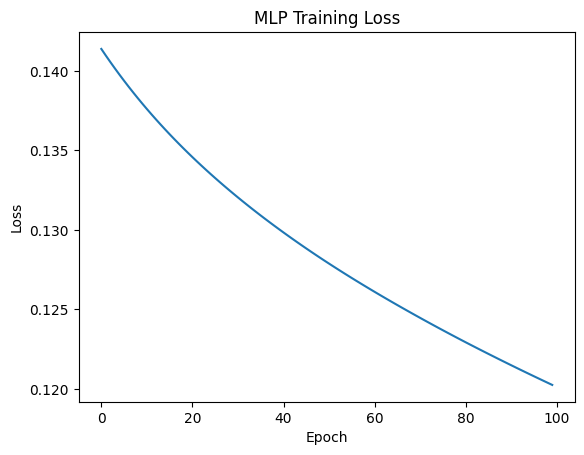

In [20]:

loss_history = []
epochs = 100

for e in range(epochs):
    net.train()
    optimizer.zero_grad()
    predictions = net(train_X_tensor)
    loss = loss_fn(predictions, train_y_tensor)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

    if (e+1) % 10 == 0:
        print(f"Epoch {e+1} | Loss: {loss.item()}")

plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MLP Training Loss')
plt.show()

In [22]:
net.eval()
with torch.no_grad():
    test_preds = net(test_X_tensor)
    final_preds = (test_preds > 0.5).float()

In [23]:
print(f"Accuracy: {accuracy_score(y_test, final_preds)}")
print("Confusion Matrix:\n", confusion_matrix(y_test, final_preds, labels=[0, 1]))
print(classification_report(y_test, final_preds, labels=[0, 1], zero_division=0))

Accuracy: 0.969
Confusion Matrix:
 [[1938    0]
 [  62    0]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1938
           1       0.00      0.00      0.00        62

    accuracy                           0.97      2000
   macro avg       0.48      0.50      0.49      2000
weighted avg       0.94      0.97      0.95      2000

